In [147]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import plotly.express as px
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from datetime import datetime

In [148]:
#define a lambda function that converts a string with format %Y-%m to datetime
custom_date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

#parse the data using pandas read_csv
AirPassengers = pd.read_csv('AirPassengers.csv', 
                            parse_dates = ['Month'], 
                            index_col   = 'Month',
                            date_parser = custom_date_parser)
AirPassengers.head()

C:\Users\sr528\AppData\Local\Temp/ipykernel_14276/870017592.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [149]:
# Let's see the data types
AirPassengers.dtypes

Passengers    int64
dtype: object

In [150]:
#Let's convert the dataFrame to a Series, since there is only one column anyways
ts = AirPassengers['Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

<AxesSubplot:xlabel='Month'>

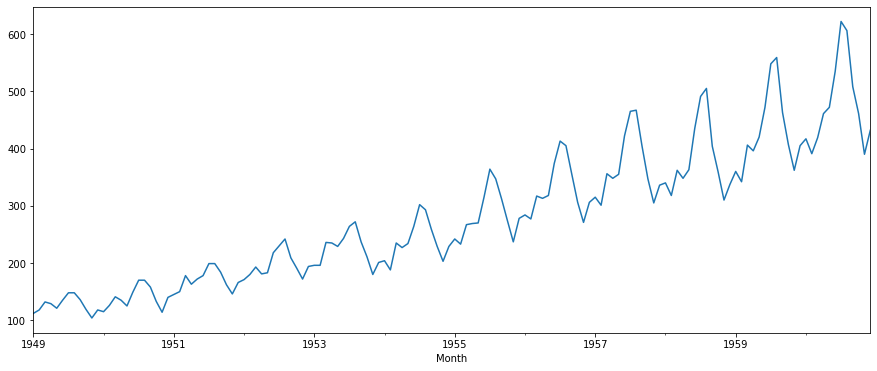

In [151]:
#visualize the time series with a simple line plot
ts.plot()

In [152]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [153]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


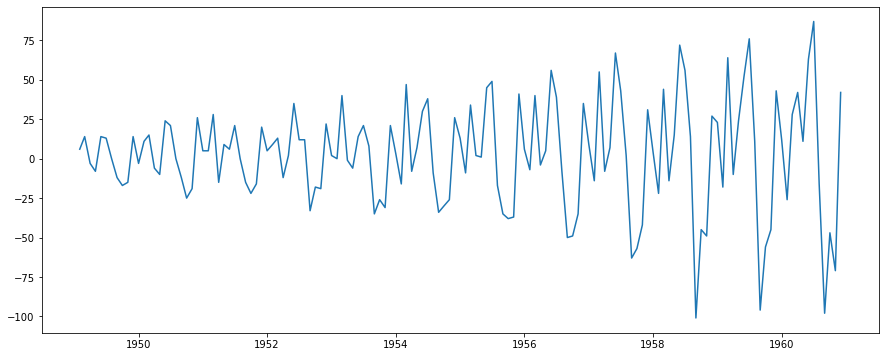

In [154]:
nonseasonal_diff = ts.diff(periods=1)
plt.plot(nonseasonal_diff)
plt.show()

In [155]:
test_stationarity(nonseasonal_diff.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


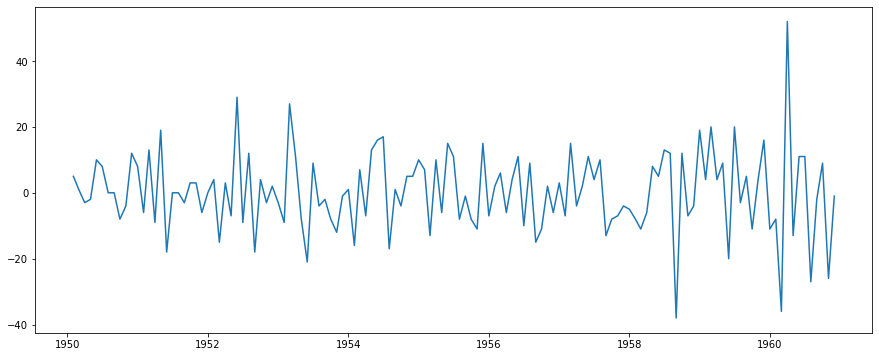

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


In [156]:
seasonal_diff = nonseasonal_diff.diff(periods=12)
plt.plot(seasonal_diff)
plt.show()
test_stationarity(seasonal_diff.dropna(inplace=False))

In [157]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [158]:
lag_acf  = acf(seasonal_diff.dropna(inplace=False), nlags=20)
lag_pacf = pacf(seasonal_diff.dropna(inplace=False), nlags=20, method='ols')

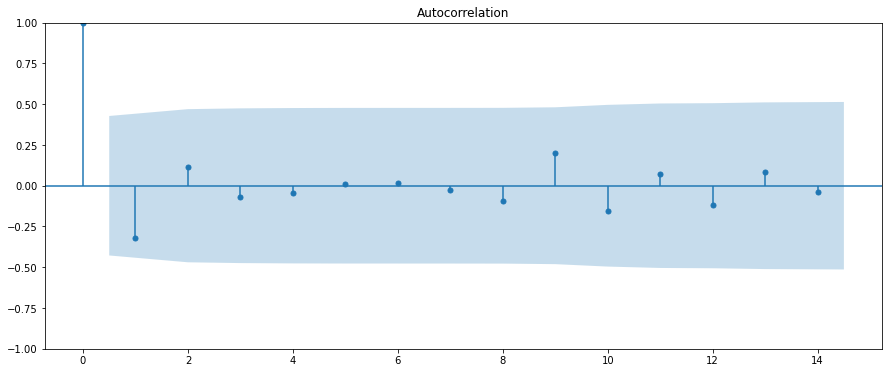

In [159]:
p=plot_acf(lag_acf)

In [160]:
def PlotAcf(data):
    fig, axes = plt.subplots(nrows=4, figsize=(8, 12))
    fig.tight_layout()

    axes[0].plot(data)
    axes[0].set_title('Raw Data')

    axes[1].acorr(data, maxlags=data.size-1)
    axes[1].set_title('Matplotlib Autocorrelation')

    plot_acf(data, lags=20, ax=axes[2])
    axes[2].set_title('Statsmodels Autocorrelation')

    pd.tools.plotting.autocorrelation_plot(data, ax=axes[3])
    axes[3].set_title('Pandas Autocorrelation')

    # Remove some of the titles and labels that were automatically added
    #for ax in axes.flat:
    #    ax.set(title='', xlabel='')
    #plt.show()

In [161]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

C:\Users\sr528\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\sr528\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



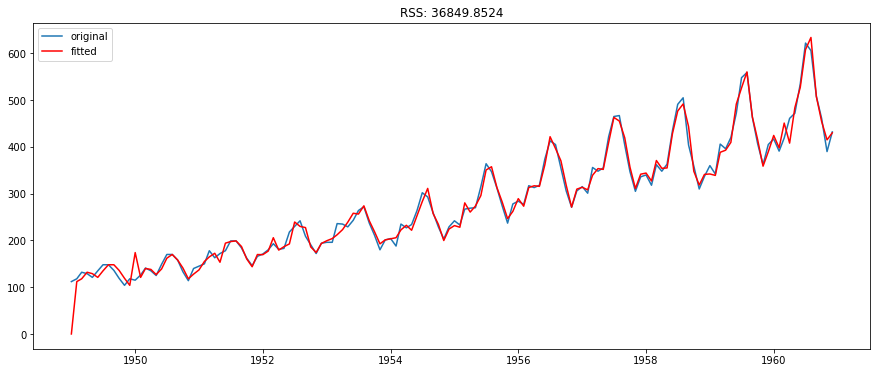

In [162]:

model = SARIMAX(ts, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts, label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='fitted')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))
plt.legend()


In [163]:
df = pd.DataFrame(ts)
df
#df['forecast'] = results_ARIMA.predict(start = '1959-05-01', end= '1960-12-01', dynamic= True)  
#df[['#Passengers', 'forecast']].plot(figsize=(12, 8))
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions-original_TS)**2)/len(original_TS)))

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [164]:
px.line(df,template = 'plotly_dark')

In [165]:
df['forecast'] = results_ARIMA.predict(start = '1950-05-01', end= '1960-12-01', dynamic= True) 
df['forecast']

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
                 ...    
1960-08-01    210.181492
1960-09-01    198.181720
1960-10-01    181.182042
1960-11-01    166.182326
1960-12-01    180.182061
Name: forecast, Length: 144, dtype: float64

In [166]:
#px.line(df["Passengers"],template = 'plotly_dark')

In [167]:
px.line(df,template = 'plotly_dark')

In [168]:
px.line(df['forecast'],template = 'plotly_dark')